# Time Series Analysis

In financial markets, data are inherently ordered in time — prices, returns, interest rates, and volatility all evolve sequentially. While linear regression models help explain relationships between variables, they often ignore the **temporal structure** of financial data. This is where **time series analysis** comes in.

Time series analysis focuses on understanding how a variable changes **over time**, identifying patterns such as **trends**, **cycles**, **autocorrelation**, and **volatility clustering**. It provides a framework for building models that not only describe historical behavior but also support **forecasting**, **risk assessment**, and **strategy development**.

In this chapter, we will explore:
- How to visualize and interpret time series data
- The concept of **stationarity** and why it matters
- How to detect and measure **autocorrelation**
- Simple models like the **AR(1)** and **random walk**
- The building blocks for more advanced models such as **GARCH** and **VAR**

Time series tools are essential in empirical finance, especially for modeling return dynamics, volatility, interest rates, and macroeconomic indicators. They allow us to ask: *How predictable are financial markets?* and *What can we learn from the past to better understand the future?*

## Time Series

A **time series** is a sequence of data points indexed in **chronological order**, typically observed at regular time intervals (e.g., daily, monthly, quarterly).

Formally, a **univariate time series** is defined as a collection of random variables:

$$
\{X_t\}_{t \in \mathbb{Z}} = \{X_1, X_2, X_3, \dots, X_T\}
$$

- $X_t$ denotes the value of the process at time $t$.
- $t$ belongs to an ordered set of time points (e.g., $t = 1, 2, \dots, T$).
- The entire sequence $\{X_t\}$ is treated as a **stochastic process**, meaning each $X_t$ is a random variable drawn from a joint distribution with the other time points.

### Example (Finance)

- $X_t$ could represent the closing price of Apple stock on trading day $t$.
- In a return series, $X_t$ would represent the log return between day $t - 1$ and day $t$.

Time series analysis focuses on modeling the **temporal dependence** between observations, which distinguishes it from cross-sectional analysis. This allows us to describe past dynamics, detect patterns, and make forecasts.

See below the visualization of the daily time series for the S&P 500 index and its discrete returns. While the index shows a steady upward trend over time, the returns do not. This upward movement is referred to as **drift**, and it captures the **average direction and speed** at which the price tends to evolve. A **positive drift** implies that the price increases on average over time. This causes the process to **"wander" away from its initial value**, making it **non-stationary**, as both its mean and variance change over time.

In contrast, the return series does not show such a trend — instead, it fluctuates around a constant average. This behavior reflects the key property of a **stationary** time series, where the statistical properties remain stable over time. Despite these differences, both time series share a common feature: their short-term movements are driven by **random fluctuations**.

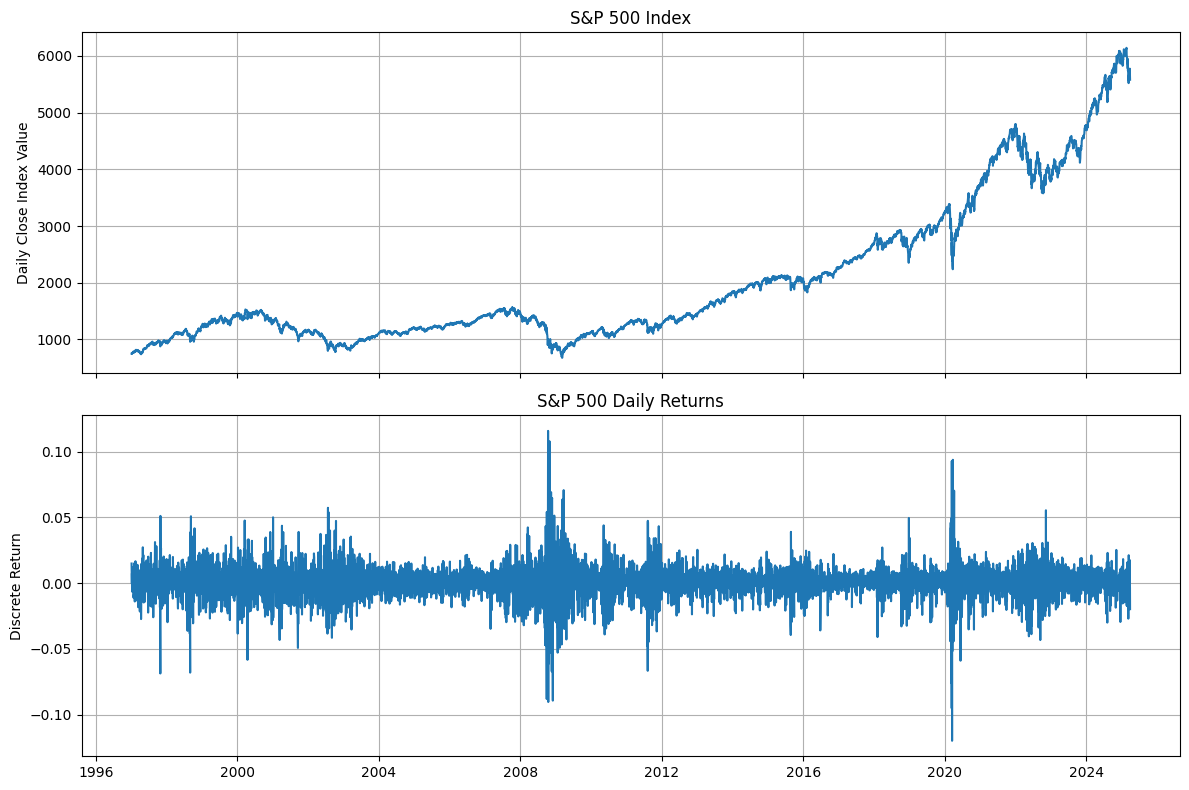

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

try:
    spx = pd.read_csv("../data/chapter_04/sp_data.csv")
    spx["Date"] = pd.to_datetime(spx["Date"])
    spx = spx.set_index("Date")
except:
    # Download S&P 500 data
    spx = yf.download("^GSPC", start="1997-01-01", auto_adjust=True)

    # Compute daily returns
    spx["Daily Return"] = spx["Close"].pct_change()
    spx = spx.iloc[1:, :]
    spx.columns = ["Close", "High", "Low", "Open", "Volume", "R_t"]
    spx.to_csv("../data/chapter_04/sp_data.csv", index = True)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(spx.index, spx["Close"], label='S&P 500 Index')
axs[0].set_title('S&P 500 Index')
axs[0].set_ylabel('Daily Close Index Value')
axs[0].grid(True)

axs[1].plot(spx.index, spx["R_t"], label='S&P 500 Returns')
axs[1].set_title('S&P 500 Daily Returns')
axs[1].set_ylabel('Discrete Return')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Autocovariance Function

In time series analysis, the **autocovariance function** describes how a variable is linearly related to its own past values. For a time series $\{X_t\}$, the autocovariance at **lag $h$** is defined as:

$$
\gamma(h) = \text{Cov}(X_t, X_{t+h}) = \mathbb{E}[(X_t - \mu)(X_{t+h} - \mu)]
$$

- $\gamma(0)$ is the **variance** of $X_t$
- $\gamma(h)$ measures the strength and direction of the **linear dependence** between $X_t$ and its lagged value $X_{t+h}$
- If $\gamma(h) > 0$, high values of $X_t$ tend to be followed by high values at lag $h$
- If $\gamma(h) < 0$, high values tend to be followed by low values, and vice versa

The autocovariance function is central to understanding the **temporal dependence structure** of a time series. In practice, we estimate autocovariance and autocorrelation from observed data. Given a time series sample $\{x_1, x_2, \dots, x_T\}$, we can compute the empirical estimators as follows:

#### Sample Mean

First, compute the sample mean:

$$
\bar{x} = \frac{1}{T} \sum_{t=1}^{T} x_t
$$

#### Sample Autocovariance Function

The **sample autocovariance** at lag $h$ is given by:

$$
\hat{\gamma}(h) = \frac{1}{T} \sum_{t=1}^{T-h} (x_t - \bar{x})(x_{t+h} - \bar{x})
$$

This measures the **linear dependence** between the time series and its lagged version, using centered observations.


### Autocorrelation Function (ACF)

The **autocorrelation function (ACF)** measures the correlation between a time series and its lagged values. For a stationary time series $\{X_t\}$, the autocorrelation at lag $h$ is defined as:

$$
\rho(h) = \frac{\gamma(h)}{\gamma(0)}
$$

- $\gamma(h)$ is the autocovariance at lag $h$
- $\gamma(0)$ is the variance of the series
- $\rho(h)$ lies between –1 and 1, and indicates the **linear dependence** between $X_t$ and $X_{t+h}$

The ACF provides insight into the **temporal structure** of the series. It is essential for identifying patterns such as persistence, seasonality, or mean reversion, and helps guide the selection of appropriate time series models.

The **sample autocorrelation** at lag $h$ is the normalized autocovariance:

$$
\hat{\rho}(h) = \frac{\hat{\gamma}(h)}{\hat{\gamma}(0)}
$$

- $\hat{\gamma}(0)$ is the **sample variance** of the time series.
- $\hat{\rho}(h)$ lies in $[-1, 1]$ and quantifies the **relative strength** of autocorrelation at lag $h$.

These estimators form the basis of the empirical autocorrelation function (ACF), a key diagnostic tool in time series analysis. A plot of $\hat{\rho}(h)$ against different lags $h$ is known as the **ACF plot** or **correlogram**, and is a standard diagnostic tool in time series analysis.

- The blue bars show the sample autocorrelation at each lag.
- The shaded area or dashed horizontal lines indicate the 95% confidence interval.
- Bars outside this range are statistically significantly different from zero at the 5% level — suggesting real time dependence at that lag.

The figure below exhibits ACF plots for daily returns of the S\&P 500, a bond ETF (IEF), Bitcoin and a Gold ETF (GLD). We observe only minor autocorrelation and the majority of autocorrelation values seem not to be statistically significantly different from zero.

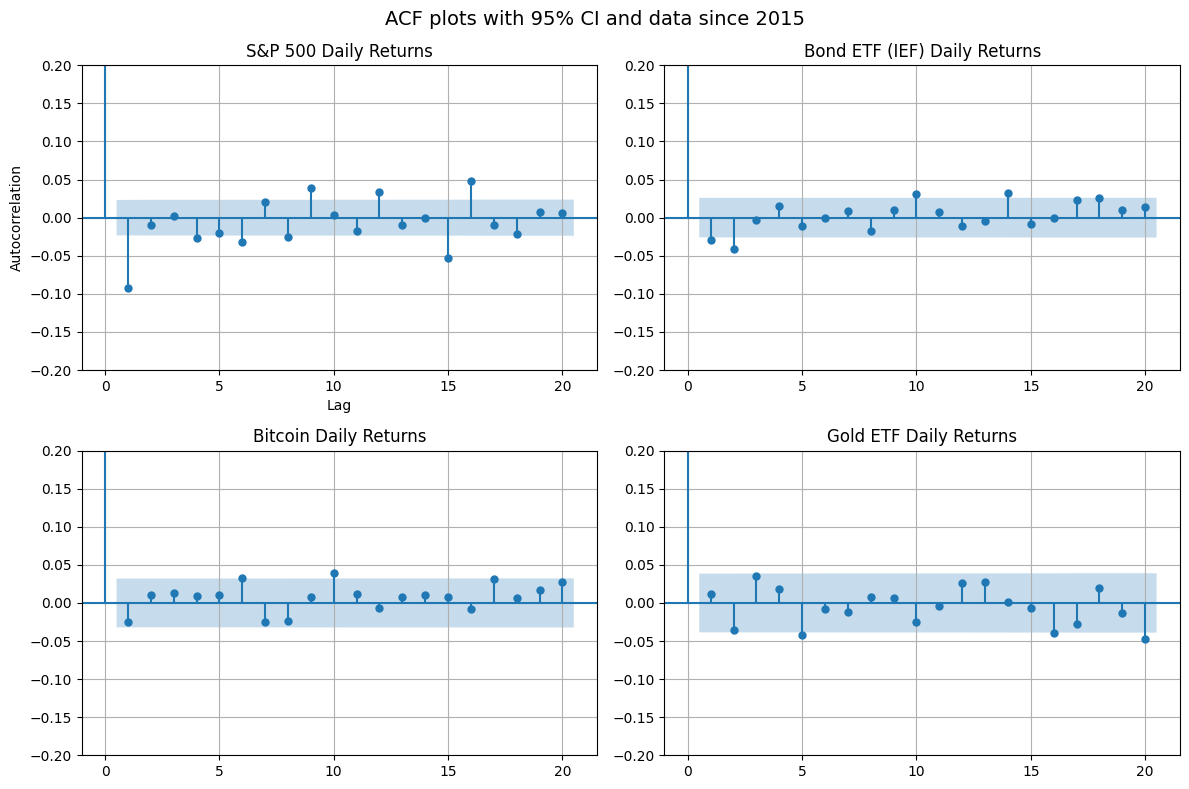

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

bond_returns = pd.read_csv("../data/chapter_04/bond_etf_returns.csv")
bond_returns["Date"] = pd.to_datetime(bond_returns["Date"])
bond_returns = bond_returns.set_index("Date")
btc = pd.read_csv("../data/chapter_04/btc_data.csv")
btc["Date"] = pd.to_datetime(btc["Date"])
btc = btc.set_index("Date")
commodity_returns = pd.read_csv("../data/chapter_04/commodity_etf_returns.csv")
commodity_returns["Date"] = pd.to_datetime(commodity_returns["Date"])
commodity_returns = commodity_returns.set_index("Date")
bond_returns.loc[btc.index[0]:, :]
spx.loc[btc.index[0]:, :]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("ACF plots with 95% CI and data since 2015", fontsize = 14)
plot_acf(spx["R_t"], lags=20, alpha=0.05, ax=axs[0, 0])
plot_acf(bond_returns["IEF"], lags=20, alpha=0.05, ax=axs[0, 1])
plot_acf(btc["R_t"], lags=20, alpha=0.05, ax=axs[1, 0])
plot_acf(commodity_returns["GLD"], lags=20, alpha=0.05, ax=axs[1, 1])

axs[0, 0].set_title("S&P 500 Daily Returns")
axs[0, 0].set_xlabel("Lag")
axs[0, 0].set_ylabel("Autocorrelation")
axs[0, 0].grid()
axs[0, 0].set_ylim(-0.2, 0.2)

axs[0, 1].set_title("Bond ETF (IEF) Daily Returns")
axs[0, 1].set_ylim(-0.2, 0.2)
axs[0, 1].grid()

axs[1, 0].set_title("Bitcoin Daily Returns")
axs[1, 0].set_ylim(-0.2, 0.2)
axs[1, 0].grid()

axs[1, 1].set_title("Gold ETF Daily Returns")
axs[1, 1].set_ylim(-0.2, 0.2)
axs[1, 1].grid()

plt.tight_layout()
plt.show()

### Definition: (Weak) Stationarity

With our knowledge of autocovariance, we can define an important concept for time series data. A time series $\{X_t\}$ is said to be **weakly stationary** (or **second-order stationary**) if the following three conditions hold:

1. **Constant mean**:
   $$
   \mathbb{E}[X_t] = \mu \quad \text{for all } t
   $$

2. **Constant variance**:
   $$
   \text{Var}(X_t) = \sigma^2 \quad \text{for all } t
   $$

3. **Autocovariance depends only on the lag**:
   $$
   \text{Cov}(X_t, X_{t+h}) = \gamma(h) \quad \text{for all } t \text{ and } h
   $$

This means the statistical properties of the series — its mean, variance, and correlation structure — are **time-invariant**.

#### Why Stationarity Matters

Most time series models, such as **ARMA**, **ARIMA**, **GARCH**, and **VAR**, are built under the assumption that the input series is **stationary**. Stationarity is important because:

- It allows us to model and forecast based on **stable patterns** over time.
- It enables meaningful estimation of **autocorrelation**, which would otherwise vary across time.
- It ensures that standard inference techniques (e.g., confidence intervals, hypothesis testing) are valid.
- Non-stationary series often contain **trends**, **unit roots**, or **changing volatility**, which can lead to **spurious regression results** if not properly addressed.

####  In Practice

- **Price series** (like stock prices) are typically **non-stationary** due to drift and increasing variance.
- **Return series** (like daily or monthly returns) are often **stationary**, making them suitable for modeling.

Identifying whether a series is stationary is one of the **first steps** in any time series analysis.

### White Noise: A Canonical Stationary Process

A **white noise process** is one of the most basic examples of a **stationary time series**. It consists of a sequence of uncorrelated random variables with constant mean and variance.

#### Definition

Let $\{\varepsilon_t\}$ be a time series. It is a **white noise process** if:

- $\mathbb{E}[\varepsilon_t] = \mu$ (constant mean) for all $t$
- $\text{Var}(\varepsilon_t) = \sigma^2$ (constant variance) for all $t$
- $\text{Cov}(\varepsilon_t, \varepsilon_{t+h}) = 0$ for all $h \ne 0$ (no autocorrelation)

This implies that each value is **statistically independent** (or at least uncorrelated) from all others — the best guess for the next value is simply the mean.

#### Intuition and Use

- White noise represents **pure randomness** — no memory, no trend, no structure.
- It is **stationary by construction**: all its moments are constant over time.
- In time series modeling, white noise is often used as:
  - A **building block** for more complex models (e.g., AR, MA, ARMA)
  - The **error term** or **innovation** driving a process
  - A **benchmark** for testing the presence of autocorrelation or structure in real data

The figure below shows simulated data from a white noise process (on the left) and its ACF plot (on the right). Comparing it to return plots from the previous chapters, we can see clear differences to real data.

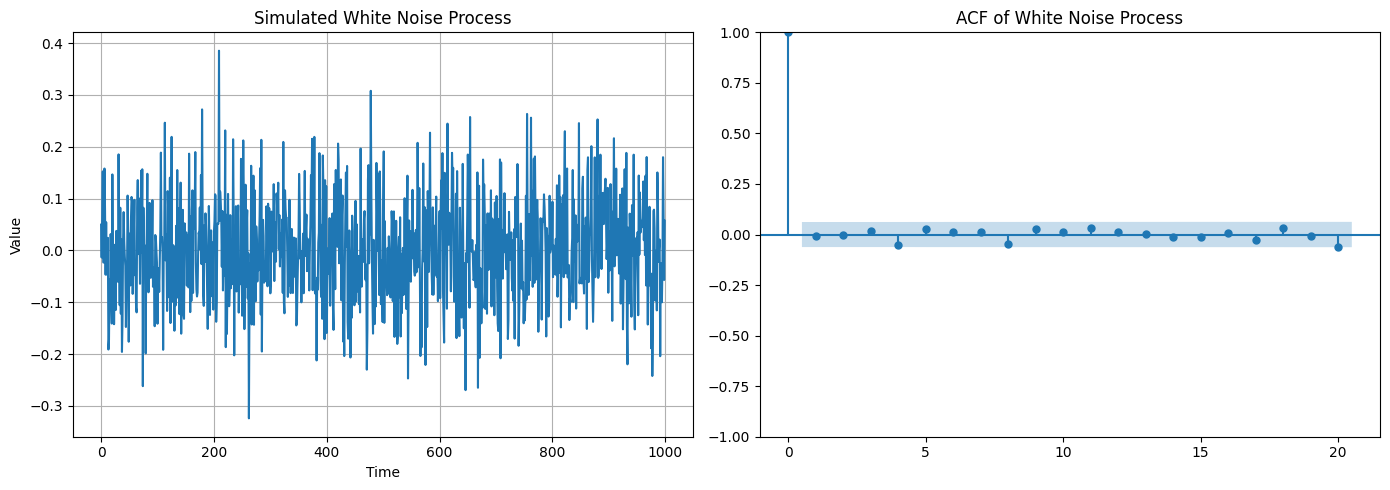

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(42)
n = 1000
white_noise = np.random.normal(loc=0, scale=.1, size=n)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(white_noise)
axs[0].set_title("Simulated White Noise Process")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Value")
axs[0].grid(True)

plot_acf(white_noise, lags=20, alpha=0.05, ax=axs[1])
axs[1].set_title("ACF of White Noise Process")

plt.tight_layout()
plt.show()

### Why White Noise Cannot Be Predicted

A white noise process represents **pure randomness** — each observation is an independent draw from the same distribution without any relation (correlation) over time and, thus, with no memory of the past. Formally, for a white noise process $\{\varepsilon_t\}$:

$$
\mathbb{E}[\varepsilon_t \mid \varepsilon_{t-1}, \varepsilon_{t-2}, \dots] = \mathbb{E}[\varepsilon_t] = \mu
$$

This means that knowing all previous values provides **no information** about future values. Unlike trend-following or mean-reverting processes, white noise contains **no structure or pattern** to exploit.

#### Intuition

- There are **no systematic components** — no drift, no trend, no autocorrelation.
- Each value is just **noise**, like flipping a fair coin or rolling a die.
- The **best prediction** for the next value is simply the mean — often zero.

#### Consequence

White noise is fundamentally **unpredictable**. Attempting to forecast it using past observations will produce no better results than guessing the mean. In time series modeling, white noise is often the **benchmark for unpredictability** and the **target residual pattern** after fitting a good model.

Thus, if we collect empirical data which seems to match a white noise process, we know that predicting its future (by its own past only) is not realistic, no matter how fancy the prediction model is going to be. 

### Ljung-Box Test

The **Ljung-Box test** is a statistical test used to detect whether a time series exhibits significant **autocorrelation** at one or more lags. It tests the **null hypothesis** that a series is **white noise**, meaning all autocorrelations up to a given lag are jointly equal to zero.

#### Hypotheses

- **Null hypothesis ($H_0$):** The data are independently distributed (no autocorrelation), i.e., $\rho(1) = \rho(2) = ... = \rho(K) = 0$, for some specified value $K$
- **Alternative hypothesis ($H_1$):** The data exhibit autocorrelation up to lag $h$.

That means a rejection of $H_0$ implies that one or more autocorrelation values up to lag ($K$) are different from zero.
#### Test Statistic

Given a sample of size $T$, and autocorrelations $\hat{\rho}_1, \hat{\rho}_2, \dots, \hat{\rho}_h$ up to lag $h$, the Ljung-Box statistic is:

$$
Q = T(T + 2) \sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{T - k}
$$

- $Q$ approximately follows a **chi-squared distribution** with $h$ degrees of freedom.
- Large values of $Q$ provide evidence **against** the null hypothesis (i.e., significant autocorrelation exists).

#### Interpretation

- If the **p-value is small** (e.g., < 0.05), we reject $H_0$: the series is **not white noise**.
- If the **p-value is large**, we do not reject $H_0$: the series behaves like white noise.

The cell below conducts the Ljung-Box test for the daily returns of the S\&P 500, a bond ETF (IEF), Bitcoin, and a gold ETF (GLD), using data since 2015. Each row shows the test statistic and p-value when including autocorrelations up to the specified lag (given by the row index). The results confirm the patterns observed in the autocorrelation function (ACF) plots: daily returns for the S\&P 500 and the bond ETF (IEF) exhibit moderate autocorrelation, whereas BTC and gold returns appear largely uncorrelated over time.

Importantly, the absence of autocorrelation does not imply that BTC and gold returns are inherently unpredictable — it simply means that past values of the same series do not contain useful information for predicting future values. In principle, one could still construct predictive models using other explanatory variables that show lagged relationships with these returns.

However, it’s crucial to emphasize that forecasting financial asset returns is a highly challenging and noisy task. Even if some predictability is found in-sample, achieving consistent and robust performance out-of-sample is rare in practice.

In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_sp = acorr_ljungbox(spx["R_t"], lags=10, return_df=True)
ljung_box_sp.columns = [("S&P 500", "test-stat"), ("S&P 500", "p-value")]
ljung_box_sp.columns = pd.MultiIndex.from_tuples(ljung_box_sp.columns)

ljung_box_bond = acorr_ljungbox(bond_returns["IEF"], lags=10, return_df=True)
ljung_box_bond.columns = [("Bond ETF(IEF)", "test-stat"), ("Bond ETF(IEF)", "p-value")]
ljung_box_bond.columns = pd.MultiIndex.from_tuples(ljung_box_bond.columns)

ljung_box_btc = acorr_ljungbox(btc["R_t"], lags=10, return_df=True)
ljung_box_btc.columns = [("BTC", "test-stat"), ("BTC", "p-value")]
ljung_box_btc.columns = pd.MultiIndex.from_tuples(ljung_box_btc.columns)

ljung_box_gold = acorr_ljungbox(commodity_returns["GLD"], lags=10, return_df=True)
ljung_box_gold.columns = [("Gold ETF(GLD)", "test-stat"), ("Gold ETF(GLD)", "p-value")]
ljung_box_gold.columns = pd.MultiIndex.from_tuples(ljung_box_gold.columns)

pd.concat((ljung_box_sp, ljung_box_bond, ljung_box_btc, ljung_box_gold), axis = 1)

S&P 500               Bond ETF(IEF)                  BTC            \
    test-stat       p-value     test-stat   p-value  test-stat   p-value   
1   61.463967  4.509202e-15      4.695152  0.030248   2.438601  0.118382   
2   62.210466  3.098625e-14     14.214595  0.000819   2.805470  0.245923   
3   62.247269  1.945331e-13     14.288471  0.002538   3.463010  0.325591   
4   67.304851  8.407579e-14     15.702897  0.003445   3.819134  0.431036   
5   70.117304  9.687751e-14     16.309565  0.006014   4.257958  0.512905   
6   77.581438  1.127749e-14     16.309568  0.012185   8.426231  0.208509   
7   80.657284  1.011638e-14     16.777778  0.018887  10.822142  0.146567   
8   85.195136  4.375645e-15     18.431887  0.018212  12.905474  0.115144   
9   95.860269  1.078672e-16     18.970966  0.025441  13.161090  0.155452   
10  95.935567  3.535106e-16     24.365616  0.006687  18.962855  0.040737   

   Gold ETF(GLD)            
       test-stat   p-value  
1       0.332197  0.564369  
2       3.686921  0.158269  
3       6.807163  0.078305  
4       7.713121  0.102671  
5      12.153010  0.032750  
6      12.315690  0.055286  
7      12.669034  0.080595  
8      12.833451  0.117710  
9      12.923192  0.166113  
10     14.491954  0.151711

Also note that the frequency of returns has a noticeable impact on the degree of autocorrelation. In the cell below, we repeat the Ljung-Box test using monthly returns instead of daily returns. The results demonstrate that autocorrelation tends to weaken or vanish at lower frequencies.

This observation is consistent with the idea that financial markets rapidly incorporate new information. Events that occurred weeks or months ago are typically already reflected in current prices, making past values less informative for predicting current returns over longer horizons. As a result, any time-dependence present in high-frequency data tends to fade as we aggregate over longer time intervals.

In [5]:
import yfinance as yf

try:
    data_for_monthly_analysis = pd.read_csv("../data/chapter_06/data_for_monthly_analysis.csv")
    data_for_monthly_analysis["Date"] = pd.to_datetime(data_for_monthly_analysis["Date"])
    data_for_monthly_analysis.set_index("Date", inplace = True)
except:
    tickers = ["^GSPC", "IEF", "BTC-USD", "GLD"]
    data_for_monthly_analysis = yf.download(tickers, start = "2015-01-01")
    data_for_monthly_analysis = data_for_monthly_analysis.loc[:, "Close"]
    data_for_monthly_analysis.columns = ["BTC", "GLD", "IEF", "S&P 500"]
    data_for_monthly_analysis.to_csv("../data/chapter_06/data_for_monthly_analysis.csv")

monthly_sp_returns = data_for_monthly_analysis["S&P 500"].resample("ME").last().pct_change().dropna()
monthly_bond_returns = data_for_monthly_analysis["IEF"].resample("ME").last().pct_change().dropna()
monthly_btc_returns = data_for_monthly_analysis["BTC"].resample("ME").last().pct_change().dropna()
monthly_gold_returns = data_for_monthly_analysis["GLD"].resample("ME").last().pct_change().dropna()

ljung_box_sp = acorr_ljungbox(monthly_sp_returns, lags=10, return_df=True)
ljung_box_sp.columns = [("S&P 500", "test-stat"), ("S&P 500", "p-value")]
ljung_box_sp.columns = pd.MultiIndex.from_tuples(ljung_box_sp.columns)

ljung_box_bond = acorr_ljungbox(monthly_bond_returns, lags=10, return_df=True)
ljung_box_bond.columns = [("Bond ETF(IEF)", "test-stat"), ("Bond ETF(IEF)", "p-value")]
ljung_box_bond.columns = pd.MultiIndex.from_tuples(ljung_box_bond.columns)

ljung_box_btc = acorr_ljungbox(monthly_btc_returns, lags=10, return_df=True)
ljung_box_btc.columns = [("BTC", "test-stat"), ("BTC", "p-value")]
ljung_box_btc.columns = pd.MultiIndex.from_tuples(ljung_box_btc.columns)

ljung_box_gold = acorr_ljungbox(monthly_gold_returns, lags=10, return_df=True)
ljung_box_gold.columns = [("Gold ETF(GLD)", "test-stat"), ("Gold ETF(GLD)", "p-value")]
ljung_box_gold.columns = pd.MultiIndex.from_tuples(ljung_box_gold.columns)

pd.concat((ljung_box_sp, ljung_box_bond, ljung_box_btc, ljung_box_gold), axis = 1)

S&P 500           Bond ETF(IEF)                  BTC            \
    test-stat   p-value     test-stat   p-value  test-stat   p-value   
1    1.710420  0.190931      0.551165  0.457842   2.758099  0.096763   
2    3.265526  0.195389      0.838684  0.657479   3.040434  0.218664   
3    3.365875  0.338579      2.995377  0.392338   4.807208  0.186471   
4    3.386461  0.495351      3.064200  0.547140   4.956758  0.291763   
5    3.453703  0.630404      3.138048  0.678713   5.399146  0.369132   
6    4.202386  0.649309      4.139121  0.657856   5.444956  0.488134   
7    6.547101  0.477505      4.151215  0.762205   5.782046  0.565417   
8    7.936803  0.439668      7.922698  0.441057   7.741067  0.459164   
9   10.081206  0.343951      8.381188  0.496234   9.242407  0.415206   
10  10.090268  0.432610      8.778285  0.553267  10.043168  0.436714   

   Gold ETF(GLD)            
       test-stat   p-value  
1       0.391872  0.531317  
2       0.466716  0.791870  
3       2.015498  0.569196  
4       2.816452  0.588996  
5       3.287300  0.655787  
6       3.669859  0.721251  
7       3.949043  0.785628  
8       4.727647  0.786249  
9       4.945886  0.839000  
10      5.400956  0.862837

## Conditional Model for the Mean: The AR(1) Model

Our analysis so far has revealed that certain financial return series — such as daily stock or bond returns — may exhibit **autocorrelation**, especially at short lags. This means that past returns contain information that could help explain or predict current returns. To model this behavior formally, we introduce the **autoregressive model of order 1**, or **AR(1)**.

The AR(1) model captures the idea that the current value of a time series depends **linearly on its most recent past value**, plus a random shock:

$$
X_t = \xi + \phi \left( X_{t-1} - \xi \right) + \varepsilon_t
$$

- $\xi$ a constant parameter
- $\phi$ is the **autoregressive coefficient** (lag-1 memory),
- $\varepsilon_t$ is a **white noise error term**.

This model is still simple, yet it introduces **persistence**, **mean-reversion**, and **predictive structure** — all features observed in many economic and financial time series. It is one of the foundational building blocks for more complex models and is essential for understanding time series dynamics beyond white noise.

Packages like `statsmodels` typically use **conditional maximum likelihood estimation**. This method assumes that the first observation is given (conditional on initial value), and then maximizes the **likelihood function** of the model under the assumption that the errors $\varepsilon_t$ are normally distributed:

$$
\varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

The conditional likelihood is then:

$$
L(\xi, \phi, \sigma^2) = \prod_{t=2}^T \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(X_t - \xi - \phi \left( X_{t-1} - \xi \right))^2}{2\sigma^2} \right)
$$

This approach is slightly more efficient than OLS and forms the foundation for likelihood-based inference and model comparison (e.g., using AIC or BIC).

In the cell below, we estimate the AR(1) model for daily returns for the S\&P 500 since 2015. The negative value for $\hat{\phi}$ implies that we expect lower returns after higher realiizations and vice versa.


In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

y = spx.loc[pd.to_datetime("2015-01-01"):, "R_t"].dropna().asfreq("B")
ar1_model = ARIMA(y, order=(1, 0, 0)).fit()
print(ar1_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    R_t   No. Observations:                 2671
Model:                 ARIMA(1, 0, 0)   Log Likelihood                7933.859
Date:                Tue, 29 Apr 2025   AIC                         -15861.718
Time:                        13:03:59   BIC                         -15844.048
Sample:                    01-02-2015   HQIC                        -15855.325
                         - 03-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.257      0.024    5.94e-05       0.001
ar.L1         -0.1373      0.008    -17.873      0.000      -0.152      -0.122
sigma2         0.0001    1.4e-06     87.959      0.0

### Using the AR(1) Model for Prediction

Once we have estimated the AR(1) model, we can use it to generate **predictions** for future values of the time series. Because the model expresses the current value as a function of the previous value, we can make **one-step-ahead forecasts** using:

$$
\hat{X}_{t+1} = \hat{\xi} + \hat{\phi} \left( X_{t-1} - \hat{\xi} \right)
$$

This forecast is the **expected value** of the next observation, conditional on the most recent observation and the estimated model parameters.

We can also generate **multi-step forecasts** recursively by feeding predictions back into the model:

- Two-step ahead: $\hat{X}_{t+2} = \hat{\xi} + \hat{\phi} \hat{X}_{t+1}$
- Three-step ahead: $\hat{X}_{t+3} = \hat{\xi} + \hat{\phi} \hat{X}_{t+2}$, and so on.

The AR(1) model is particularly useful for predicting time series that exhibit **persistence** or **mean-reversion**, and it provides a foundation for more complex forecasting models in time series analysis.

Let us take a look how well such a model is good for out-of-sample forecasting. The data starts at 2015, we use data until the end of 2022 to estimate the parameters of the AR(1) model and use it to forecast data starting in 2023. A benchmark is to use the arithmetic mean of returns between 2015 and 2022. To compare the models we calculate the residuals for each day:

$$
\varepsilon_t = y_t - \hat{y}_t
$$

and sum their squared values:

$$
SSE = \sum_{t = 1}^T \varepsilon_t^2
$$

Hereby, we insert either the arithmetic mean or the AR(1) prediction for $\hat{y}_t$.

When we do this for our example, the AR(1) model performs worse than the arithmetic mean. It even performs worse in comparison to a model which predicts zero $\hat{y}_t = 0$ for every day. The reason for this may be a small overfit of the AR(1) model and the low level of autocorrelation and high level of randomness.

In [7]:
arithmetic_mean = y.loc[:pd.to_datetime("2023-01-01")].mean()
ar1_predictions = ar1_model.predict(start = pd.to_datetime("2023-01-03"))
e_arithmetic = y.loc[pd.to_datetime("2023-01-03"):] - arithmetic_mean
e_ar1 = y.loc[pd.to_datetime("2023-01-03"):] - ar1_predictions
print(f"SSE for the arithmetic mean: {e_arithmetic.apply(lambda x: x**2).sum():.4f}")
print(f"SSE for the AR(1) model: {e_ar1.apply(lambda x: x**2).sum():.4f}")
print(f"SSE for zero return predictions of every day: {y.loc[pd.to_datetime("2023-01-03"):].apply(lambda x: x**2).sum():.4f}")

SSE for the arithmetic mean: 0.0393
SSE for the AR(1) model: 0.0401
SSE for zero return predictions of every day: 0.0396


### Beyond AR(1): AR(p) and ARMA Models

While the AR(1) model captures dependence on a single lag, many time series exhibit **longer memory**, where the current value is influenced by several past observations. In such cases, we can generalize to an **autoregressive model of order $p$**, or **AR(p)** by inserting past realizations with higher lags. Further extensions also include past resiudals. These models are Moving Average (MA) models. Combining them gives aus ARMA models. 

Despite its worse performance in our example, studying the AR(1) model is a reasonable part of this chapter. While we see that future prediction of returns is very challenging, we are going to see that predicting the variance is more promising. 

## Conditional Model for the Variance: The GARCH(1, 1) model

So far, we have focused on analyzing the **autocorrelation of returns**. Overall, we observed at most moderate autocorrelation, and saw how difficult it is to predict returns in the presence of high randomness. Recall that the variance of a random variable measures the expected squared deviation from its mean. For simplicity, let us now assume that the mean of daily returns is approximately zero — a reasonable approximation given our earlier findings, where even the AR(1) model failed to significantly outperform the historical mean.

Under this assumption, variance can be approximated by the squared values of return realizations. The ACF plots shown in the cell below visualize the **autocorrelation of squared returns** for the four asset classes we previously studied. Compared to the raw return series, the squared returns exhibit stronger and consistently positive autocorrelation. This implies that large deviations from zero — whether positive or negative — tend to be followed by further large deviations. This is consistent with the earlier observation of volatility clustering.

These elevated autocorrelation levels suggest that models based on past squared returns may have greater predictive power than those focused on the mean alone. This motivates a shift in focus: from modeling expected returns, to modeling conditional variance — a key idea we explore with GARCH models in the next section.

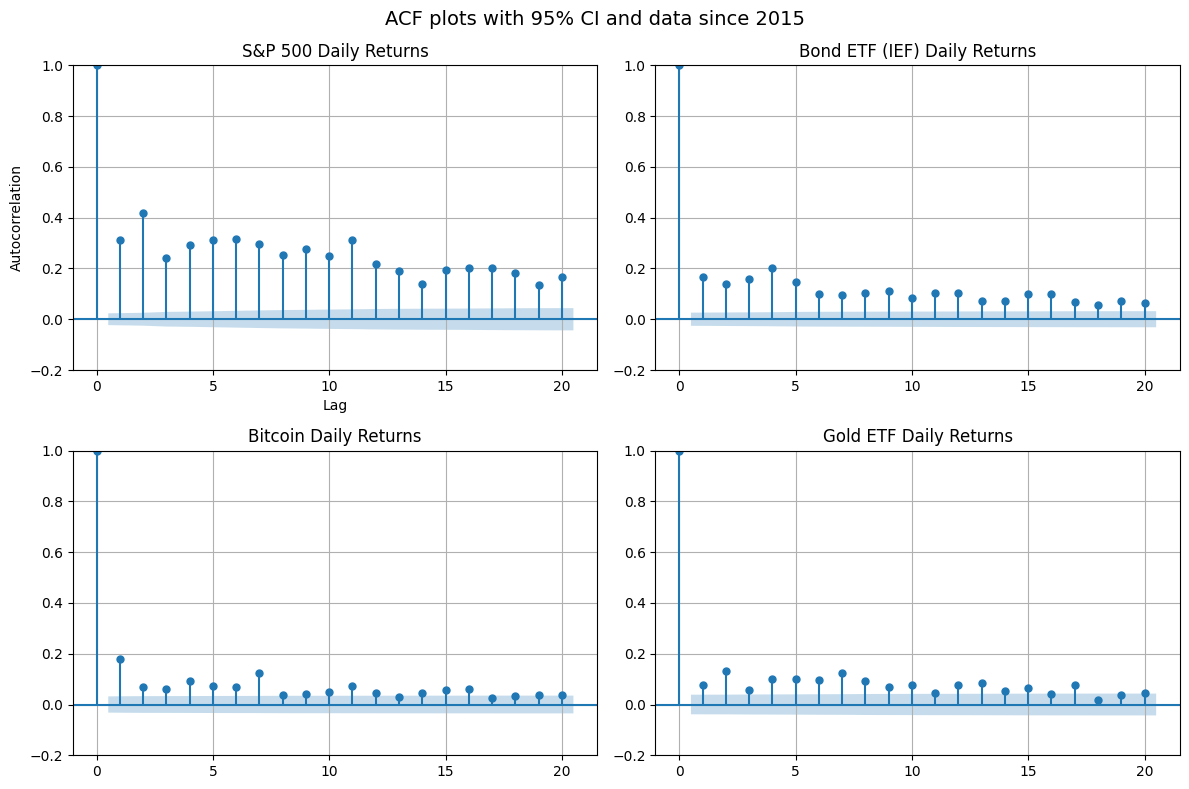

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

bond_returns = pd.read_csv("../data/chapter_04/bond_etf_returns.csv")
bond_returns["Date"] = pd.to_datetime(bond_returns["Date"])
bond_returns = bond_returns.set_index("Date")
btc = pd.read_csv("../data/chapter_04/btc_data.csv")
btc["Date"] = pd.to_datetime(btc["Date"])
btc = btc.set_index("Date")
commodity_returns = pd.read_csv("../data/chapter_04/commodity_etf_returns.csv")
commodity_returns["Date"] = pd.to_datetime(commodity_returns["Date"])
commodity_returns = commodity_returns.set_index("Date")
bond_returns.loc[btc.index[0]:, :]
spx.loc[btc.index[0]:, :]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("ACF plots with 95% CI and data since 2015", fontsize = 14)
plot_acf(spx["R_t"]**2, lags=20, alpha=0.05, ax=axs[0, 0])
plot_acf(bond_returns["IEF"]**2, lags=20, alpha=0.05, ax=axs[0, 1])
plot_acf(btc["R_t"]**2, lags=20, alpha=0.05, ax=axs[1, 0])
plot_acf(commodity_returns["GLD"]**2, lags=20, alpha=0.05, ax=axs[1, 1])

axs[0, 0].set_title("S&P 500 Daily Returns")
axs[0, 0].set_xlabel("Lag")
axs[0, 0].set_ylabel("Autocorrelation")
axs[0, 0].grid()
axs[0, 0].set_ylim(-0.2, 1.0)

axs[0, 1].set_title("Bond ETF (IEF) Daily Returns")
axs[0, 1].set_ylim(-0.2, 1.0)
axs[0, 1].grid()

axs[1, 0].set_title("Bitcoin Daily Returns")
axs[1, 0].set_ylim(-0.2, 1.0)
axs[1, 0].grid()

axs[1, 1].set_title("Gold ETF Daily Returns")
axs[1, 1].set_ylim(-0.2, 1.0)
axs[1, 1].grid()

plt.tight_layout()
plt.show()

### GARCH(1,1) Model Definition

Just as the **AR model** captures temporal dependence in the **conditional mean** of a time series, the **GARCH model** focuses on modeling the **conditional variance**. We begin with a general stochastic process of the form:

$$
X_t = \mu_t + \varepsilon_t
$$

Here, $\mu_t$ represents the **conditional mean**, which can be specified using any appropriate time series model (e.g., AR(1), ARMA, or simply a constant). For example, under an AR(1) structure:

$$
\mu_t = \xi + \phi (X_{t-1} - \xi)
$$

To focus purely on the variance, we often simplify by assuming the mean is constant and equal to zero:

$$
\mu_t = \mu = 0 \quad \Rightarrow \quad X_t = \varepsilon_t
$$

The key idea of the GARCH model is that the **shock term $\varepsilon_t$ has time-varying volatility**. We represent this by:

$$
\varepsilon_t = \sigma_t Z_t
$$

where:
- $\sigma_t^2$ is the **conditional variance** at time $t$ (i.e., variance given past information),
- $Z_t$ is a white noise process with $\mathbb{E}[Z_t] = 0$ and $\operatorname{Var}(Z_t) = 1$.

#### Formal Definition: GARCH(1,1)

The **GARCH(1,1)** model (Generalized Autoregressive Conditional Heteroskedasticity) specifies the conditional variance $\sigma_t^2$ as a linear function of:
- a constant,
- the **lagged squared shock** ($\varepsilon_{t-1}^2$), and
- the **previous conditional variance** ($\sigma_{t-1}^2$):

$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

with the constraints:
- $\omega > 0$, $\alpha \geq 0$, $\beta \geq 0$,
- and usually $\alpha + \beta < 1$ to ensure **stationarity** (i.e., finite long-run variance).

This model captures the observed behavior in financial time series where **large shocks tend to cluster**, and periods of high volatility are followed by more volatile periods — a phenomenon known as **volatility clustering**. The model parameters are usually estimated by conditional maximum-likelihood estimation. 

#### One-Step-Ahead Volatility Prediction with GARCH(1,1)

The estimated GARCH(1,1) model is used to generate one-step-ahead forecasts of conditional variance (i.e., volatility squared). Once the parameters $\hat{\omega}$, $\hat{\alpha}$, and $\hat{\beta}$ are estimated, the forecast for the next period's variance is given by:

$$
\hat{\sigma}_{t+1}^2 = \hat{\omega} + \hat{\alpha} \cdot \varepsilon_t^2 + \hat{\beta} \cdot \hat{\sigma}_t^2
$$

Where:
- $\varepsilon_t^2$ is the most recent squared return innovation (shock),
- $\hat{\sigma}_t^2$ is the most recent estimated conditional variance.

This equation updates the forecasted volatility using the most recent information. The one-step-ahead forecast is widely used in applications such as risk management, volatility trading, and Value-at-Risk (VaR) estimation.

To initialize the recursion, the GARCH model uses historical return data to compute the residuals $\varepsilon_t$ and conditional variances $\sigma_t^2$. The starting values for these variables are typically set using the unconditional variance or backfilled from the estimation period using the fitted model.

#### Interpretation of model parameters

The parametrization of the GARCH(1, 1) enables us to get insights into the dynamic behavior of volatility:

- The persistence of volatility is measured by $\alpha + \beta$. If it’s close to 1, shocks to volatility die out slowly — a key feature of financial time series.
- $\alpha$ captures the “news” effect (how much recent shocks influence volatility).
- $\beta$ captures volatility persistence (how much past volatility propagates).

In the cell below, we estimate a GARCH(1,1) model for the S&P 500 (daily returns) using data between 1997 and 2017. The estimated parameters $\hat{\alpha} = 0.095$ and $\hat{\beta} = 0.895$ suggest that:

- Volatility is highly persistent, as the sum $\hat{\alpha} + \hat{\beta} = 0.99$ is close to 1.
- Recent shocks to returns (squared innovations) have a moderate short-term effect on future volatility through $\hat{\alpha}$.
- The high value of $\hat{\beta}$ indicates that past volatility contributes significantly to current conditional volatility, reflecting slow decay of volatility over time.

In [9]:
import pandas as pd
from arch import arch_model

returns = spx["R_t"].dropna().multiply(100)

# Define cutoff date for in-sample vs out-of-sample
cutoff = pd.to_datetime("2017-12-31")
model = arch_model(returns, mean="Zero", vol='GARCH', p=1, q=1)
garch_fit = model.fit(disp="off", last_obs=cutoff)

print(garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    R_t   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7394.37
Distribution:                  Normal   AIC:                           14794.7
Method:            Maximum Likelihood   BIC:                           14814.5
                                        No. Observations:                 5284
Date:                Tue, Apr 29 2025   Df Residuals:                     5284
Time:                        13:03:59   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0151  4.458e-03      3.388  7.046e-04 [6.

The cell below illustrates the development of conditional volatlity for the time-series in sample (data from 1997 until 2017) and out of sample (data starting from 2018). We observe how well the GARCH(1, 1) model captures times of low and high volatilty regimes as well as volatility clustering.

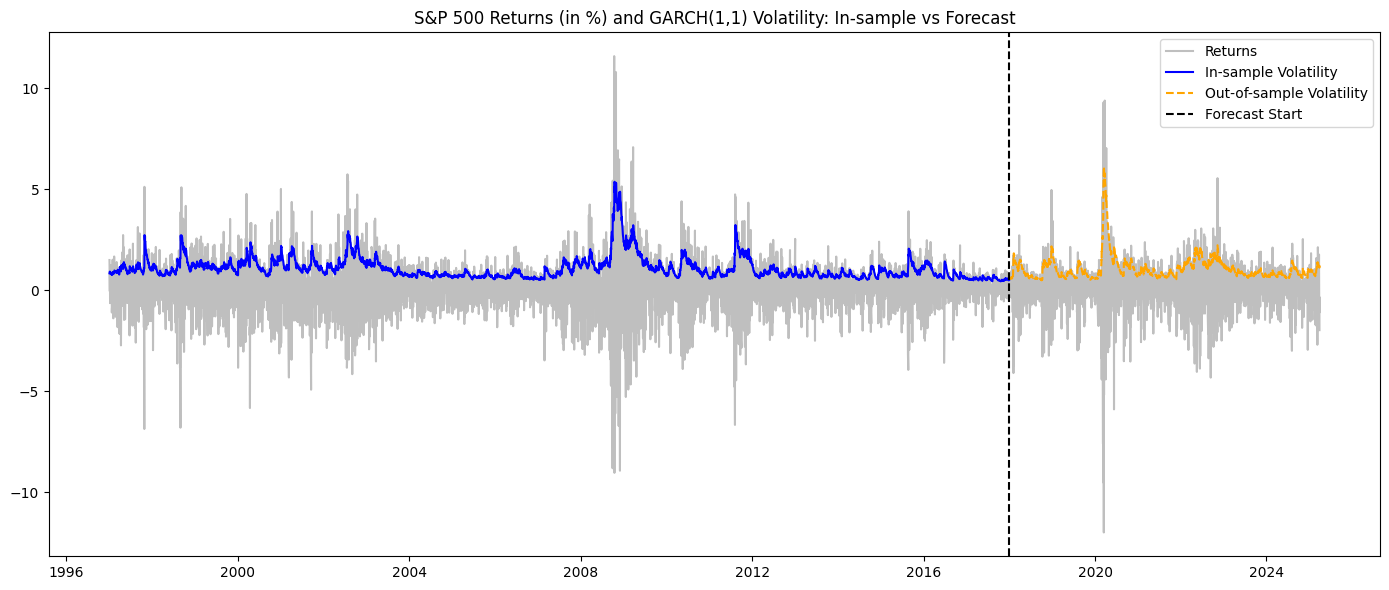

In [10]:
import matplotlib.pyplot as plt

forecasts = garch_fit.forecast(start=cutoff + pd.Timedelta(days=1))

# Align conditional volatility (in-sample) and forecasts (out-of-sample)
cond_vol = garch_fit.conditional_volatility  # in-sample vol
forecast_vol = forecasts.variance["h.1"]**0.5  # out-of-sample forecasted vol (sqrt to get std)

# Combine everything into one DataFrame
vol_df = pd.DataFrame({
    "Returns": returns,
    "Conditional Volatility": cond_vol,
    "Forecasted Volatility": forecast_vol
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(vol_df["Returns"], label="Returns", color="gray", alpha=0.5)
plt.plot(vol_df["Conditional Volatility"], label="In-sample Volatility", color="blue")
plt.plot(vol_df["Forecasted Volatility"], label="Out-of-sample Volatility", color="orange", linestyle="--")
plt.axvline(cutoff, color="black", linestyle="--", label="Forecast Start")
plt.title("S&P 500 Returns (in %) and GARCH(1,1) Volatility: In-sample vs Forecast")
plt.legend()
plt.tight_layout()
plt.show()

#### Comparing GARCH Forecasts to Unconditional Volatility

To evaluate the accuracy of volatility forecasts, we compare the **conditional volatility predictions** from the GARCH(1,1) model to a simple benchmark: the **unconditional historical standard deviation** of returns estimated from the in-sample period.

We assess each forecast's performance by computing the **mean squared error (MSE)** between the predicted variance and the realized squared returns in the out-of-sample period:

$$
\text{MSE} = \frac{1}{T} \sum_{t=1}^{T} \left( r_t^2 - \hat{\sigma}_t^2 \right)^2
$$

Where:
- $ r_t^2 $ is the realized squared return at time $t$,
- $ \hat{\sigma}_t^2 $ is the predicted conditional variance from the GARCH model or the square of the unconditional standard deviation.

A lower MSE indicates a better approximation of actual return variability. If the GARCH model's MSE is smaller than that of the unconditional variance forecast, it suggests that the model adds value by capturing time-varying volatility more effectively.

Calculating the MSE for the out of sample period below demonstrates that the GARCH(1,1) model is better in capturing volatilty dynamics with daily frequency.

In [11]:
in_sample_returns = returns[returns.index <= cutoff]
out_sample_returns = returns[returns.index > cutoff]

realized_var = out_sample_returns ** 2
uncond_var = in_sample_returns.var()
forecast_var = forecasts.variance["h.1"]

comparison_df = pd.DataFrame({
    "Realized Variance": realized_var.values,
    "GARCH Variance": forecast_var,
    "Uncond Variance": uncond_var,
}, index=out_sample_returns.index)

garch_mse = np.mean((comparison_df["Realized Variance"] - comparison_df["GARCH Variance"]) ** 2)
uncond_mse = np.mean((comparison_df["Realized Variance"] - comparison_df["Uncond Variance"]) ** 2)

print(f"GARCH MSE: {garch_mse:.4f}")
print(f"Unconditional MSE: {uncond_mse:.4f}")

GARCH MSE: 21.3804
Unconditional MSE: 35.2074


### Economic Importance of Weak Return Autocorrelation and Persistent Volatility

Empirical analysis of daily stock returns often reveals that **returns themselves exhibit little to no autocorrelation**, while **volatility is highly persistent**. This observation has several important economic implications:

- **Market Efficiency**: The absence of strong autocorrelation in returns supports the Efficient Market Hypothesis (EMH), which posits that asset prices reflect all available information. If returns were predictable based on past returns, it would suggest arbitrage opportunities, violating the EMH.

- **Volatility Clustering**: The persistence of volatility means that periods of high or low volatility tend to cluster. This is consistent with the idea that new information arrives in bursts or that investors react gradually to information. Persistent volatility affects how traders and risk managers assess and respond to market risk.

- **Risk Management**: Since return shocks have long-lasting effects on volatility, models like GARCH are valuable tools for **forecasting risk**. These forecasts feed into portfolio optimization, margin setting, and Value-at-Risk (VaR) models.

In summary, while daily returns themselves may not be predictable, the **predictability of volatility** has deep implications for financial practice, from asset pricing to trading and risk control. For instance, a GARCH(1,1) model may be used to track recent volatility behavior and signal when investors may shift their fundings to safer investments such as bonds. 

### Conditional vs Unconditional Mean and Variance Estimators

Time series models usually provide conditional estimators for, e.g., the mean and the volatilty. Conditional in this context means, **given recent information**, which values and levels of variation do we expect next. In comparison, unconditional estimators do not include this information, however, include level values and variation over different market conditions. This may be summarized as follows:

- **Unconditional estimators** assume that returns are independently and identically distributed (i.i.d.) over time. They compute a single, constant mean or variance across the entire sample:
  - **Unconditional mean**: the average return over the sample period.
  - **Unconditional variance**: the variance of returns over the full sample.
  - These are static estimates that do not respond to new information or recent market conditions.

- **Conditional estimators**, by contrast, allow the mean and/or variance to change over time, depending on available information (usually past returns or volatility).
  - **Conditional mean**: estimated as a time-varying function, often via models like AR or ARMA.
  - **Conditional variance**: estimated using models like GARCH, which allow volatility to evolve based on past shocks and volatility.
  - These estimates adapt to market dynamics and are more suitable for forecasting and risk management.

In essence, **unconditional estimators provide long-run average behavior**, while **conditional estimators capture time-varying dynamics and short-run dependencies** in financial data.

### Summary: Modeling Conditional Mean and Variance — Univariate and Multivariate Perspectives

In financial econometrics, modeling the **conditional mean and variance** of asset returns is essential for understanding return dynamics, forecasting, and managing risk. While this chapter has focused primarily on univariate models, it's important to note that **many different modeling approaches** can be used depending on the data characteristics and the purpose of analysis.

#### Modeling the Conditional Mean
- The conditional mean captures the predictable component of returns, typically modeled using:
  - **AR (AutoRegressive) models**
  - **MA (Moving Average) and ARMA models**
  - **ARIMA/ARIMAX models** when trends or exogenous variables are involved
  - **Regime-switching or state-space models** to capture structural shifts

#### Modeling the Conditional Variance
- The conditional variance reflects time-varying risk, often modeled using:
  - **ARCH/GARCH models** for volatility clustering
  - **EGARCH, GJR-GARCH** to capture asymmetries (e.g., leverage effects)
  - **Stochastic volatility models** for more flexible dynamics
  - **Rolling or expanding window estimators** as non-parametric alternatives

#### Multivariate Extensions
In real-world applications, financial assets are rarely analyzed in isolation. Modeling interactions across multiple return series requires **multivariate frameworks**:

- **Vector Autoregressive (VAR) models**: Extend univariate AR models to capture dynamic interdependencies across multiple time series. Useful for analyzing spillovers, impulse responses, and forecast systems of returns.

- **Multivariate GARCH (MGARCH) models**: Extend GARCH to multiple assets to model time-varying covariances and correlations.
  - Common specifications include:
    - **VECH and Diagonal VECH models**: Directly model each element of the conditional covariance matrix.
    - **BEKK models**: Ensure positive definiteness of the covariance matrix.
    - **Dynamic Conditional Correlation (DCC) GARCH**: Allows for time-varying correlations in a computationally efficient way.

These multivariate models are particularly important in:
- **Portfolio optimization** and **risk budgeting**
- **Systemic risk monitoring** and **contagion analysis**
- **Macro-finance modeling** and **monetary policy transmission**

#### Final Note
The choice of model depends on the research question, data properties, and computational constraints. Understanding the interplay between mean and variance dynamics — both univariate and multivariate — is a foundational skill in modern financial econometrics.